In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras import backend as K
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
#load cifar10 train-test datasets
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [3]:
#define No of classes
num_classes = len(np.unique(Y_train))
num_classes

10

In [4]:
# get train dimension
X_train.shape

(50000, 32, 32, 3)

In [5]:
# get test dimension
Y_train.shape

(50000, 1)

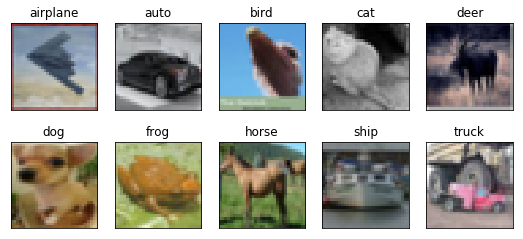

In [6]:
#show examples for each class

class_names = ['airplane','auto','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(9,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(Y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    ax.set_title(class_names[i])
    plt.imshow(features_idx[img_num,::])
plt.show()

In [7]:
#data pre-processing

#Converting everything to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
    
X_train.shape

(50000, 32, 32, 3)

In [8]:
# convert class labels to binary class labels (one-hot)

Y_train = np_utils.to_categorical(Y_train, num_classes)
Y_test = np_utils.to_categorical(Y_test, num_classes)

In [9]:
# check sample response class img is in one - hot encoding form
# we need the target to be a 10-dimensional vector that is all-zeros except for a 1 at the index corresponding to the 
# the class of the sample, because afterwards we are using the categorical_crossentropy loss which requires our
# targets to be in categorical format.
Y_train[3]

array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [10]:
# performance plots

def plot_performance(model):
    fig, axs = plt.subplots(1,2,figsize=(13,4))
    
    # Accuracy
    axs[0].plot(range(1,len(model.history['acc'])+1),model.history['acc'])
    axs[0].plot(range(1,len(model.history['val_acc'])+1),model.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model.history['acc'])+1),len(model.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Loss
    axs[1].plot(range(1,len(model.history['loss'])+1),model.history['loss'])
    axs[1].plot(range(1,len(model.history['val_loss'])+1),model.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model.history['loss'])+1),len(model.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [11]:
# calculating accuracy
def accuracy(X_test, Y_test, model):
    result = model.predict(X_test)
    pred_class = np.argmax(result, axis=1)
    true_class = np.argmax(Y_test, axis=1)
    num_correct = np.sum(pred_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [12]:
# setup the model

#image input dimensions
#img_rows = 32
#img_cols = 32
#img_channels = 3

#number of convulation filters to use
#filters = 32
#size of pooling area for max pooling
#pool_size = (2, 2)
#convolution kernel size
#kernel_size = (3, 3)

model = Sequential()
# 1st convolutional layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd convolutional layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

# 3rd convolutional layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten()) # this converts our 3D feature maps to 1D feature vectors

# Fully connected layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# Output. Softmax output since we'd like to get some probabilities.
model.add(Dense(num_classes, activation='softmax'))

In [13]:
# CNN structure
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 64)        0         
__________

In [ ]:
#compile the model
adam =Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
#Data Augmentation 
train_gen = ImageDataGenerator(featurewise_center=True, # set input mean to 0 over the dataset
                               featurewise_std_normalization=True, # divide inputs by std of the dataset
                               vertical_flip=True, # randomly flip images
                               rotation_range=25) # randomly rotate images in the range (degrees, 0 to 180)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_gen.fit(X_train)
# Fit the model on the batches generated by datagen.flow().
start = time.time()
fitted_model_2 = model.fit_generator(train_gen.flow(X_train, Y_train, batch_size=32),
                                      epochs=50,
                                      steps_per_epoch=len(X_train),
                                      validation_data = (X_test, Y_test), 
                                      verbose=1)
end = time.time()


# plot model history
plot_performance(fitted_model_2)

# compute test accuracy
print ("Test data Accuracy: %0.2f"%accuracy(X_test, Y_test, model))
result_loss_acc=model.evaluate(X_test, Y_test, batch_size=32)
print('Test Loss_Acc: ', result_loss_acc)

##############################################################################################################
# !!!! Due to high training time requirements locally, we moved the training procedure in Microsoft Azure !!!!
##############################################################################################################

Epoch 1/50
50000/50000 [==============================] - 9443s - loss: 0.9419 - acc: 0.6670 - val_loss: 11.0107 - val_acc: 0.2946
Epoch 2/50
50000/50000 [==============================] - 9417s - loss: 0.7438 - acc: 0.7397 - val_loss: 11.9252 - val_acc: 0.2474
Epoch 3/50
50000/50000 [==============================] - 9463s - loss: 0.6870 - acc: 0.7603 - val_loss: 11.7486 - val_acc: 0.2573
Epoch 4/50
50000/50000 [==============================] - 9438s - loss: 0.6564 - acc: 0.7724 - val_loss: 12.8875 - val_acc: 0.1945
Epoch 5/50
50000/50000 [==============================] - 9475s - loss: 0.6378 - acc: 0.7798 - val_loss: 12.9149 - val_acc: 0.1880
Epoch 6/50
50000/50000 [==============================] - 9551s - loss: 0.6263 - acc: 0.7849 - val_loss: 12.2091 - val_acc: 0.2205
Epoch 7/50
50000/50000 [==============================] - 9834s - loss: 0.6192 - acc: 0.7884 - val_loss: 12.6089 - val_acc: 0.2070
Epoch 8/50
50000/50000 [==============================] - 10213s - loss: 0.6165 - a

In [ ]:
# confusion matrix
def plot_confusion_matrix(predicted_classes):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    result = model.predict(X_test)
    cm = confusion_matrix(y_true=np.argmax(Y_test, axis=1),  # True class for test-set.
                          y_pred=np.argmax(result, axis=1))  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [ ]:
result = model.predict(X_test)
#predictions classes by taking the class with the highest prob 
y_pred=np.argmax(result, axis=1)

In [ ]:
print("Confusion Matrix:")
plot_confusion_matrix(y_pred)